# Lab 1 (classic CV)

## Подготовка данных

### Импортирем нужные библиотеки

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Вспомогательные функции

In [2]:
def plt_imshow_rgb(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pass

In [3]:
def plt_imshow_gray(img):
    plt.imshow(img, cmap='gray')
    pass

### Читаем изображение

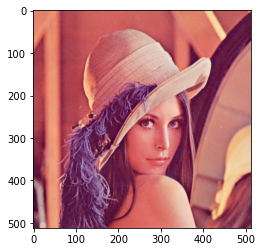

In [4]:
image = cv2.imread("./lena.jpg")
plt_imshow_rgb(image)

## Ищем лицо на изображении (обрабатываем лишь первое найденное лицо)

In [5]:
def find_face_coords(img):
    cascade_path = "./haarcascade_frontalface_default.xml"
    face_cascade_classifier = cv2.CascadeClassifier(cascade_path)
    faces = face_cascade_classifier.detectMultiScale(image)
    face_coords = faces[0]
    return face_coords

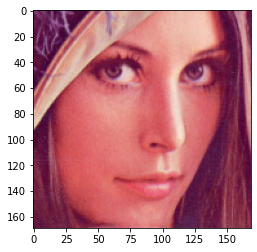

In [6]:
face_coords = find_face_coords(image)
x, y, w, h = face_coords
plt_imshow_rgb(image[x : x + w, y : y + h])

## Получаем фрагмент изображения, отступив на 10% от границ лица

In [7]:
def get_face_fragment(img, face_coords, percent):
    x, y, w, h = face_coords
    p_frac = percent / 100
    w_add = w * p_frac
    h_add = h * p_frac
    x_add = w_add / 2
    y_add = h_add / 2
    x_new = int(x - x_add if x > x_add else x)
    y_new = int(y - y_add if y > y_add else y)
    w_new = int(w + w_add)
    h_new = int(h + h_add)
    face_fragment = img[x_new : x_new + w_new, y_new : y_new + h_new]
    return face_fragment

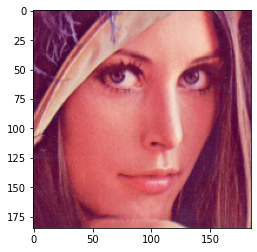

In [8]:
face_fragment = get_face_fragment(image, face_coords, 10)
plt_imshow_rgb(face_fragment)

## Получаем бинарное изображение краев (границ объектов)

In [9]:
def get_edges(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img_gray, 100, 200)
    return edges

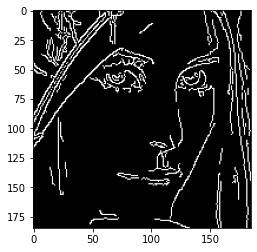

In [10]:
edges = get_edges(face_fragment)
plt_imshow_gray(edges)

## Удаляем мелкие границы (у которых длина и ширина <10)

In [11]:
def remove_small_edges(img_edges, h_size, w_size):
    only_big_edges_img = np.zeros_like(img_edges)
    big_contours = []
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w >= w_size or h >= h_size:
            big_contours.append(contour)
    cv2.drawContours(only_big_edges_img, big_contours, -1, (255, 255, 255))
    big_edges = only_big_edges_img
    return big_edges

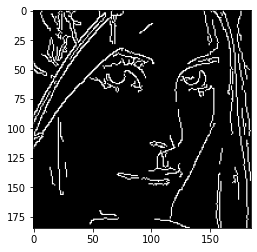

In [12]:
only_big_edges = remove_small_edges(edges, 10, 10)
plt_imshow_gray(only_big_edges)

## Применяем морфологическую операцию наращивания (размер ядра: 5x5)

In [13]:
def dilatation(img, kernel_size):
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    dilatation = cv2.dilate(img, kernel)
    return dilatation

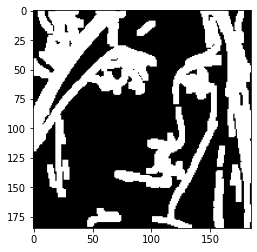

In [14]:
dilated_edges = dilatation(only_big_edges, 5)
plt_imshow_gray(dilated_edges)

## Сглаживаем изображение краев (фильтром Гаусса с ядром: 5x5) и получаем нормализированное изображение $M$

In [15]:
def edges_filter(edges):
    kernel_size = 5
    blured_edges = cv2.GaussianBlur(edges, (kernel_size, kernel_size), 0)
    result = cv2.normalize(blured_edges, None, 0, 1, cv2.NORM_MINMAX)
    return result

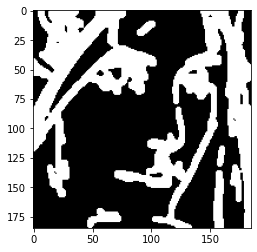

In [16]:
M = edges_filter(dilated_edges)
plt_imshow_gray(M)

## Получаем изображение $F_1$ (с помощью билатериального фильтра)

In [17]:
def f1_img_filter(img):
    img_f1 = cv2.bilateralFilter(img, 15, 50, 20)
    return img_f1

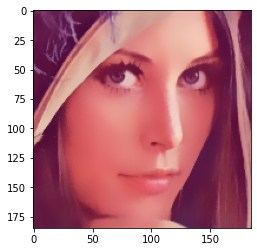

In [18]:
F1 = f1_img_filter(face_fragment)
plt_imshow_rgb(F1)

## Получаем изображение $F_2$ с помощью улучшения четкости/контрастности:
  + I - img
  + G - blured_img
  + G' - mixed_blur
$$I_1 = I - G$$
$$G' = 
\begin{cases}
   I &\text{if $I_1 \leq T$}\\
   G &\text{if $I_1 > T$}
\end{cases}$$
$$I_2 = I - G'$$
$$F_2 = I + k*I_2 = I*(k + 1) - k*G'$$

In [19]:
def f2_img_filter(img, T, k):
    kernel_size = 5
    blured_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img1 = cv2.cvtColor(img - blured_img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(img1, T, 255, cv2.THRESH_BINARY)
    mask = np.uint8(mask)
    inverse_mask = cv2.bitwise_not(mask)
    G = cv2.bitwise_and(blured_img, blured_img, mask=mask)
    I = cv2.bitwise_and(img, img, mask=inverse_mask)
    mixed_blur = cv2.bitwise_or(I, G)
    img_f2 = cv2.addWeighted(img, 1+k, mixed_blur, -k, 0)
    return img_f2

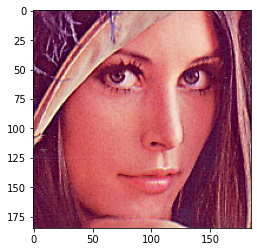

In [20]:
F2 = f2_img_filter(face_fragment, 10, 2)
plt_imshow_rgb(F2)

## Осуществляем финальную фильтрацию по формуле: $$R[x, y, c] = M[x, y] * F_2[x, y, c] + (1 - M[x, y]) * F_1[x, y, c]$$

In [21]:
def final_filter(M, F1, F2):
    M = np.expand_dims(M, axis=2)
    R = M * F2 + (1 - M) * F1
    return R

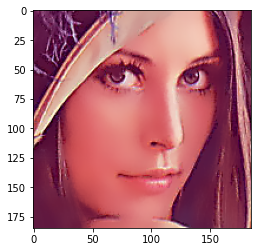

In [22]:
result_image = final_filter(M, F1, F2)
plt_imshow_rgb(result_image)